# Parameter Optimization With scipy Differential Evolution

In [1]:
%matplotlib inline
import model_fitting as mf

from collections import namedtuple
import lmfit   # Fitting lib
import matplotlib.pyplot as plt 
import math
import numpy as np
import pandas as pd
import random
from scipy.optimize import differential_evolution
import tellurium as te

## Model And Synthetic Data

In [2]:
# Model
model = """
     A -> B; k1*A
     B -> C; k2*B
      
     A = 5;
     B = 0;
     C = 0;
     k1 = 0.1
     k2 = 0.2
"""
parameters = mf.makeParameters(constants=['k1', 'k2'])

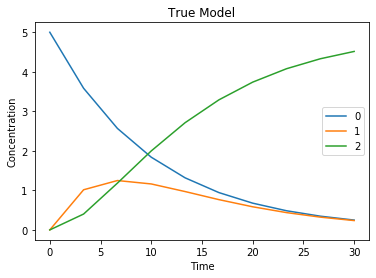

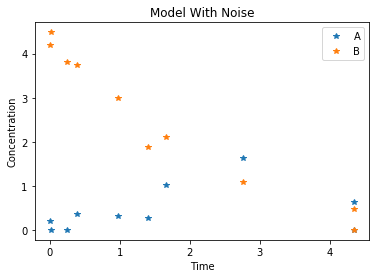

In [3]:
# Create synthetic observational data and plot it.
result_true = mf.runSimulation(model=model, num_points=10)
df_obs = mf.makeObservations(model=model, noise_std=0.5, num_points=10)
columns = ['A', 'B', 'C']
mf.plotTimeSeries(result_true.data, title="True Model", columns=columns)
mf.plotTimeSeries(df_obs, title="Model With Noise", is_scatter=True, columns=columns)

## Fitting With Option for lmfit or Scipy

In [4]:
PARAMETERS = lmfit.Parameters()
PARAMETERS.add('k1', value=1, min=0, max=10)
PARAMETERS.add('k2', value=1, min=0, max=10)
ROAD_RUNNER = None
ME_LEASTSQ = "leastsq"
ME_DIFFERENTIAL_EVOLUTION = "differential_evolution"
ME_BOTH = "both"

In [5]:
def fit(obs_data, indices=None, parameters=PARAMETERS, 
    method=ME_LEASTSQ, is_scipy=True, **kwargs):
  """ 
  Does a fit of the model to the observations.
  :param ndarray obs_data: matrix of observed values with time
                           as the first column
         pd.DataFrame    : time is index
  :param list-int indices: indices on which fit is performed
  :param lmfit.Parameters parameters: parameters fit
  :param str method: optimization method; both means
                     differential_evolution followed by leastsq
  :param dict kwargs: optional parameters passed to runSimulation
  :return lmfit.Parameters:
  """
  global road_runner  # Used to avoid repeatedly loading the model
  road_runner = ROAD_RUNNER
  names = parameters.valuesdict().keys()
  #
  def calcFitResiduals(values):
    global road_runner
    if isinstance(values, lmfit.Parameters):
        calc_parameters = values
        is_lmfit = True
    else:
        calc_parameters = mf.makeParameters(names, values)
        is_lmfit = False
    residual_calculation = mf.calcSimulationResiduals(obs_data,
        calc_parameters, indices, road_runner=road_runner, **kwargs)
    road_runner = residual_calculation.road_runner
    if is_lmfit:
        residuals = residual_calculation.residuals
    else:
        residuals = np.var(residual_calculation.residuals)
    return residuals
  #
  def estimateParametersWithLmfit(method, parameters):
    # Estimate the parameters for this fold
    fitter = lmfit.Minimizer(calcFitResiduals, parameters)
    fitter_result = fitter.minimize(method=method)
    return fitter_result.params
  #
  def estimateParametersWithScipy():
    bounds = [(p[1].min, p[1].max) for p in parameters.items()]
    mins = [b[0] for b in bounds]
    maxs = [b[1] for b in bounds]
    result = differential_evolution(calcFitResiduals, bounds)
    values = result.x.tolist()
    new_parameters = mf.makeParameters(names, values=values, mins=mins, maxs=maxs)
    return new_parameters
    
  if is_scipy:
    return estimateParametersWithScipy()
  else:
    if method == ME_BOTH:
      parameters = estimateParametersWithLmfit(ME_DIFFERENTIAL_EVOLUTION,
          parameters)
      return estimateParametersWithLmfit(ME_LEASTSQ, parameters)
    else:
      return estimateParametersWithLmfit(method, parameters)


In [6]:
#Fitting using lmfit produces good results for both k1~0.1 and k2~.2
fit(df_obs, model=model, parameters=parameters, is_scipy=False)

name,value,standard error,relative error,initial value,min,max,vary
k1,0.09189030,0.00596444,(6.49%),1,0.00000000,10.0000000,True
k2,0.22314349,0.03080798,(13.81%),1,0.00000000,10.0000000,True


In [7]:
# Fitting using scipy. Very poor estimate of k2; off by a factor of 2.
fit(df_obs, model=model, parameters=parameters, is_scipy=True)

name,value,initial value,min,max,vary
k1,0.12665270,0.1266527043962838,0.00000000,10.0000000,True
k2,3.61194818,3.611948175349777,0.00000000,10.0000000,True


## Standalone Example of Using scipy Differential Evolution

In [8]:
# Simple example of using scipy differential evolution
#  1. The objective function (center) takes a list of parameter values. it returns
#      a float, not a list of residuals.
#  2. Scipy differential_evolution takes as arguments the objective function
#     and a list of bounds for the solution.
points = [(1,1), (2,2), (1,0), (0, 4)]
def center(x):
    x_res = [p[0] - x[0] for p in points]
    y_res = [p[1] - x[1] for p in points]
    residuals = list(x_res)
    residuals.extend(y_res)
    return sum([r*r for r in residuals])
#
bounds = [(-5, 5), (-5, 5)]
result = differential_evolution(center, bounds)
result.x, result.fun

(array([0.99999999, 1.75      ]), 10.75)